<a href="https://colab.research.google.com/github/PasinduDil/Behavioral-Captioning-from-Image/blob/main/Behavioral_Captioning_from_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch torchvision pillow groq

In [ ]:
# Import necessary libraries
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import requests
from io import BytesIO
import os
from groq import Groq
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Mount Google Drive to access images
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize Groq
groq_api_key = "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"# Replace  API key
groq_client = Groq(api_key=groq_api_key)

In [ ]:
# Load BLIP model for image captioning
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


In [ ]:
# Load ViT-GPT2 model for more detailed captions
vit_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vit_feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
vit_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [ ]:
def load_image(image_path):
    """
    Load image from Google Drive path or URL
    """
    try:
        if image_path.startswith('http'):
            response = requests.get(image_path)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

In [ ]:
# Generate caption using BLIP model
def generate_blip_caption(image):
    """
    Generate caption using BLIP model
    """
    try:
        inputs = blip_processor(image, return_tensors="pt")
        out = blip_model.generate(**inputs, max_length=50, num_beams=5,temperature=0.9,repetition_penalty=1.2)
        caption = blip_processor.decode(out[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error with BLIP captioning: {e}")
        return None

In [ ]:
# Generate caption using ViT-GPT2 model
def generate_vit_caption(image):
    """
    Generate caption using ViT-GPT2 model
    """
    try:
        pixel_values = vit_feature_extractor(images=[image], return_tensors="pt").pixel_values
        output_ids = vit_model.generate(pixel_values, max_length=40, num_beams=5,temperature=0.9)
        caption = vit_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error with ViT captioning: {e}")
        return None

In [ ]:
# Generate multiple captions for better behavioral inference
def generate_comprehensive_caption(image):
    """
    Generate multiple captions and combine them for richer description
    """
    captions = []

    # BLIP caption
    blip_caption = generate_blip_caption(image)
    if blip_caption:
        captions.append(f"BLIP: {blip_caption}")

    # ViT-GPT2 caption
    vit_caption = generate_vit_caption(image)
    if vit_caption:
        captions.append(f"ViT-GPT2: {vit_caption}")

    return captions

In [ ]:
behavioral_prompt_template = """Image Captions:{captions}

    Analyze the behavior shown in this image:

    1. Primary Activity: What is the main behavior or activity?
    2. Behavioral Context: What does this suggest about the person's state of mind?
    3. Social Dynamics: How are people interacting (if multiple people)?
    4. Environmental Influence: How does the setting affect the behavior?
    5. Behavioral Summary: Provide a 2-3 sentence behavioral description."""

In [ ]:
def analyze_behavior_with_groq(captions):
    """
    Use Groq LLM to analyze behavior from image captions
    """
    try:
        # Combine captions into a single string
        caption_text = "\n".join(captions)

        # Format the prompt
        prompt = behavioral_prompt_template.format(captions=caption_text)

        # Call Groq API
        completion = groq_client.chat.completions.create(
            model="qwen-qwq-32b",
            messages=[
                {"role": "system", "content": "You are an expert behavioral analyst."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=1000
        )
        return completion.choices[0].message.content

    except Exception as e:
        print(f"Error with Groq behavioral analysis: {e}")
        return "Unable to perform behavioral analysis at this time."

In [ ]:
def complete_behavioral_analysis(image_path, display_image=True):
    print(f"Processing image: {image_path}")
    print("="*60)

    # Load image
    image = load_image(image_path)
    if image is None:
        return "Failed to load image"

    # Display image if requested
    if display_image:
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()

    # Generate captions
    print("Generating image captions...")
    captions = generate_comprehensive_caption(image)

    if not captions:
        return "Failed to generate captions"

    # Display captions
    print("\n Generated Captions:")
    for caption in captions:
        print(f"  • {caption}")

    # Behavioral analysis
    print("\nPerforming behavioral analysis...")
    behavioral_analysis = analyze_behavior_with_groq(captions)

    print("\nBEHAVIORAL ANALYSIS RESULTS:")
    print("="*60)
    print(behavioral_analysis)

    return behavioral_analysis

print("Complete behavioral captioning pipeline ready!")

Complete behavioral captioning pipeline ready!


Processing image: /content/14.jpg


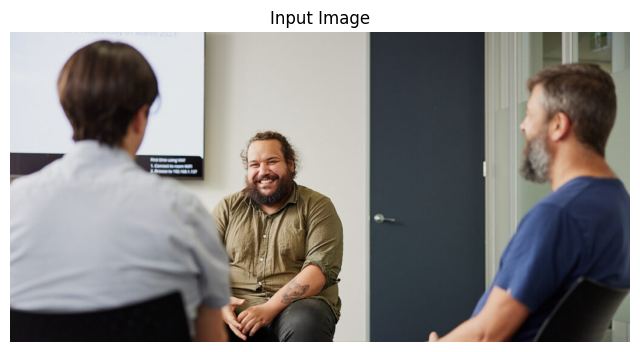

Generating image captions...

 Generated Captions:
  • BLIP: a man sitting on a chair in front of a projector
  • ViT-GPT2: two men standing next to each other in a room 

Performing behavioral analysis...

BEHAVIORAL ANALYSIS RESULTS:

<think>
Okay, I need to analyze the image described here. The user provided two different image captions from different models: BLIP says a man is sitting on a chair in front of a projector, and ViT-GPT2 says two men are standing next to each other in a room. Hmm, there's a discrepancy here. Maybe I should start by clarifying the details.

First, I should figure out what the actual image might look like. Since there's a conflict between the two captions, maybe the image has both elements. Perhaps the man is sitting in front of a projector, and there's another person nearby, so two men are present. That might mean both descriptions are partially correct. 

Now, moving to the primary activity: The main activity here would depend on the correct setup. If t

"\n<think>\nOkay, I need to analyze the image described here. The user provided two different image captions from different models: BLIP says a man is sitting on a chair in front of a projector, and ViT-GPT2 says two men are standing next to each other in a room. Hmm, there's a discrepancy here. Maybe I should start by clarifying the details.\n\nFirst, I should figure out what the actual image might look like. Since there's a conflict between the two captions, maybe the image has both elements. Perhaps the man is sitting in front of a projector, and there's another person nearby, so two men are present. That might mean both descriptions are partially correct. \n\nNow, moving to the primary activity: The main activity here would depend on the correct setup. If there's a projector, maybe the man is operating it or presenting something. If two men are present, they might be collaborating or discussing something related to the projector. The context could be a classroom, an office, or a co

In [ ]:
complete_behavioral_analysis('/content/14.jpg')

Processing image: /content/rzh-bus-stop-17.jpg


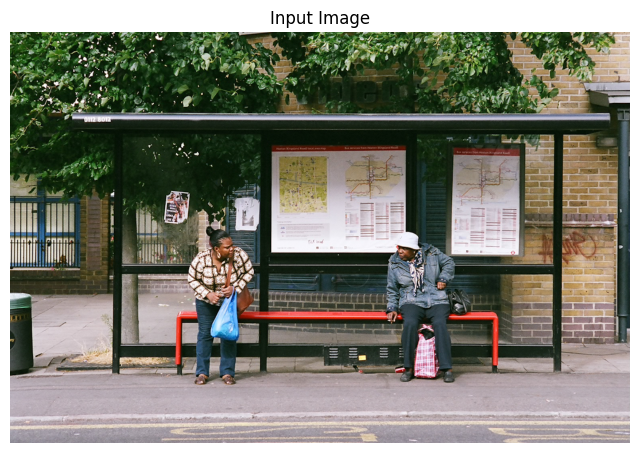

Generating image captions...

 Generated Captions:
  • BLIP: two people sitting on a bench in front of a bus stop
  • ViT-GPT2: a man and woman sitting on a bench near a bus stop 

Performing behavioral analysis...

BEHAVIORAL ANALYSIS RESULTS:

<think>
Okay, so I need to analyze the behavior in this image where two people are sitting on a bench near a bus stop. Let's start with the primary activity. The main thing they're doing is sitting, right? But maybe there's more to it. Are they waiting for the bus? That's a common reason to be at a bus stop. So the primary activity could be waiting, but the BLIP and ViT-GPT2 captions mention sitting on the bench. Maybe the main activity is just sitting, but with the context of being at a bus stop. Hmm, maybe the primary activity is waiting for public transport. That makes sense because the bus stop is part of the scene.

Next, the behavioral context. If they're waiting, what does that suggest about their state of mind? Well, waiting can be a pa

'\n<think>\nOkay, so I need to analyze the behavior in this image where two people are sitting on a bench near a bus stop. Let\'s start with the primary activity. The main thing they\'re doing is sitting, right? But maybe there\'s more to it. Are they waiting for the bus? That\'s a common reason to be at a bus stop. So the primary activity could be waiting, but the BLIP and ViT-GPT2 captions mention sitting on the bench. Maybe the main activity is just sitting, but with the context of being at a bus stop. Hmm, maybe the primary activity is waiting for public transport. That makes sense because the bus stop is part of the scene.\n\nNext, the behavioral context. If they\'re waiting, what does that suggest about their state of mind? Well, waiting can be a passive activity, but it might indicate they\'re on a routine, like commuting to work or school. Alternatively, they might be waiting to meet someone. Or maybe they\'re just lingering there for no particular reason. Since they\'re at a b

In [ ]:
complete_behavioral_analysis('/content/rzh-bus-stop-17.jpg')

Processing image: /content/12.jpg


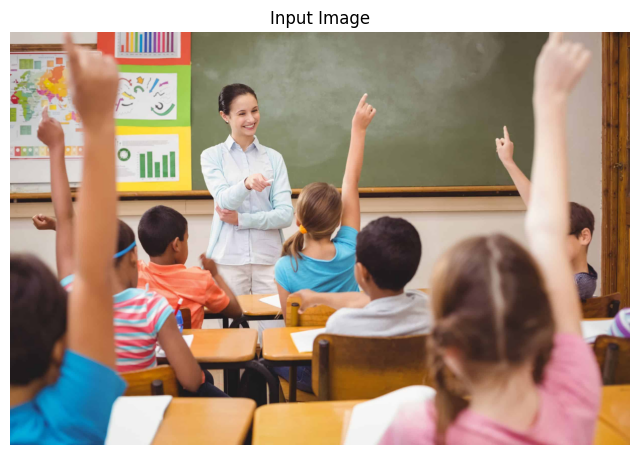

Generating image captions...

 Generated Captions:
  • BLIP: a group of children raising their hands in a classroom
  • ViT-GPT2: a classroom filled with students and a teacher 

Performing behavioral analysis...

BEHAVIORAL ANALYSIS RESULTS:

<think>
Okay, let's tackle this analysis. The user provided two image captions from BLIP and ViT-GPT2. The BLIP caption says "a group of children raising their hands in a classroom," and ViT-GPT2's is "a classroom filled with students and a teacher." The task is to analyze the behavior shown in the image based on these captions across five points.

First, I need to figure out the primary activity. The key action here is the children raising their hands. That's a common classroom behavior, usually indicating they want to answer a question or participate. So the main activity is probably active participation through hand-raising.

Next, the behavioral context. When kids raise their hands in class, it usually suggests they're engaged and eager to co

'\n<think>\nOkay, let\'s tackle this analysis. The user provided two image captions from BLIP and ViT-GPT2. The BLIP caption says "a group of children raising their hands in a classroom," and ViT-GPT2\'s is "a classroom filled with students and a teacher." The task is to analyze the behavior shown in the image based on these captions across five points.\n\nFirst, I need to figure out the primary activity. The key action here is the children raising their hands. That\'s a common classroom behavior, usually indicating they want to answer a question or participate. So the main activity is probably active participation through hand-raising.\n\nNext, the behavioral context. When kids raise their hands in class, it usually suggests they\'re engaged and eager to contribute. They might feel confident or motivated. But maybe some could be seeking approval or afraid of speaking out otherwise. I should consider both possibilities here.\n\nSocial dynamics: There are multiple people—students and a 

In [ ]:
complete_behavioral_analysis('/content/12.jpg')